In [1]:
from hydromt_sfincs import SfincsModel, utils
import numpy as np
from os.path import join
import hydromt
import glob
import pandas as pd
from datetime import timedelta
import xarray as xr
import os
import matplotlib.pyplot as plt

## read flood and model data

In [201]:
mdir = r"../../3_models"
rdir = r"../../4_results"

In [51]:
index_cols = ['h_rp','p_rp','qb_rp','qp_rp']
ds = xr.open_zarr(join(rdir, 'hmax.zarr'))
da1 = ds['hmax']#.isel(scen=slice(0,100)).load()

In [21]:

df_sample = pd.read_csv(join(rdir, r'sim_EVENTS_rp.csv'), index_col=0).rename(columns={'h_tsw_rp': 'h_rp', 'h_tsw': 'h'})


df_flood = da1.reset_coords().drop_vars(['count', 'spatial_ref', 'x', 'y', 'hmax']).to_dataframe()
# df_flood[index_cols] = np.maximum(1, df_flood[index_cols])
ds_flood_rp = df_flood.reset_index().drop(columns=index_cols).set_index(
    pd.MultiIndex.from_frame(df_flood[index_cols])
).to_xarray()
ds_flood_rp['index'] = ds_flood_rp['index'].fillna(-1).astype(int)
ds_flood_rp


<xarray.Dataset>
Dimensions:  (h_rp: 9, p_rp: 9, qb_rp: 9, qp_rp: 9)
Coordinates:
  * h_rp     (h_rp) int64 0 2 5 10 25 50 100 250 500
  * p_rp     (p_rp) int64 0 2 5 10 25 50 100 250 500
  * qb_rp    (qb_rp) int64 0 2 5 10 25 50 100 250 500
  * qp_rp    (qp_rp) int64 0 2 5 10 25 50 100 250 500
Data variables:
    scen     (h_rp, p_rp, qb_rp, qp_rp) object 'qb000_qp000_h000_p000' ... 'q...
    index    (h_rp, p_rp, qb_rp, qp_rp) int32 15 14 47 81 122 ... -1 -1 -1 2283

## flood impact assessment

In [202]:
# log-linear integration from FIAT
def get_logcov(rp_lst):
    f_lst = [1 / i for i in rp_lst]
    lf = [np.log(1 / i) for i in rp_lst]
    c = [(1 / (lf[i] - lf[i+1])) for i in range(len(rp_lst[:-1]))]
    G = [(f_lst[i] * lf[i] - f_lst[i]) for i in range(len(rp_lst))]
    a = [((1 + c[i] * lf[i+1]) * (f_lst[i] - f_lst[i+1]) + c[i] * (G[i+1] - G[i])) for i in range(len(rp_lst[:-1]))]
    b = [(c[i] * (G[i] - G[i+1] + lf[i+1] * (f_lst[i+1] - f_lst[i]))) for i in range(len(rp_lst[:-1]))]
    if len(rp_lst) == 1:
        cov_lst = f_lst
    else:
        cov_lst = [b[0] if i == 0 else f_lst[i] + a[i-1] if i == len(rp_lst) - 1 else a[i-1] + b[i] for i in range(len(rp_lst))]

    return cov_lst

def loglin_trapz(exp, rp_lst=None):
    if rp_lst is None:
        rp_lst = (1/(1-np.arange(exp.size)/exp.size)).tolist()
    exp_lst = np.sort(exp).tolist()
    cov_lst = get_logcov(rp_lst)
    risk = (np.asarray(cov_lst) * np.asarray(exp_lst)).sum()
    return risk

In [203]:
hmin = 0.15

# small edit to set threshold for impact at 15cm
df = pd.read_csv(join(mdir, 'fiat', 'susceptibility', 'AF000.csv'), index_col=0)
df.columns = ['factor']
df.index.name = 'depth'
df[df.index<hmin] = 0
ds_exp = hydromt.open_mfraster(join(mdir, 'fiat', 'exposure', '*.tif')).load()

In [26]:
samples = {'obs': df_sample[df_sample['year']<=500]}
# for postfix in ['_magInd_timeObs', '_magInd_timeInd', '_magObs_timeObs']:
#     fn = os.path.join('../02_data', f'modelled_dataset_5000_years{postfix}_rp.csv')
#     samples[postfix[1:]] = pd.read_csv(fn, index_col=0)

In [204]:

def flood_damage(da_flddph, da_exposure, df_susceptibility, **kwargs):
    nodata = da_exposure.attrs['_FillValue']
    da0 = df_susceptibility.to_xarray()['factor'].chunk({'depth':-1})
    factor = np.minimum(1, da0.interp(depth=da_flddph, **kwargs))
    damage = (factor * da_exposure).fillna(nodata).astype(np.float32)
    damage.name = da_exposure.name
    damage.attrs.update(**da_exposure.attrs)
    return damage

def flood_exposed(da_flddph, da_exposure, min_flddph=hmin):
    exposed = xr.where(da_flddph>min_flddph,da_exposure,0.0).astype(np.float32)
    exposed.attrs.update(**da_exposure.attrs)
    exposed.name = da_exposure.name
    return exposed



## base scenario

In [212]:
# flood impact univariate and full dep compound scenario
rps = np.array([0, 2,5,10,25,50,100,250,500], dtype=int)

da_qb = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'qb_rp*.tif'), concat=True, concat_dim='rps')
da_qp = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'qp_rp*.tif'), concat=True, concat_dim='rps')
da_h = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'h_rp*.tif'), concat=True, concat_dim='rps')
da_p = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'p_rp*.tif'), concat=True, concat_dim='rps')
da_c0 = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'compound_fulldep_rp*.tif'), concat=True, concat_dim='rps').rename({'compound': 'fulldep'})
da_c1 = hydromt.open_mfraster(os.path.join(rdir, 'hmax', f'compound_indep_rp*.tif'), concat=True, concat_dim='rps').rename({'compound': 'indep'})
ds = xr.merge([da_qb, da_qp, da_h, da_p, da_c0, da_c1]).raster.flipud()
# rps[0] = 1
# ds['rps'] = xr.IndexVariable('rps', rps)
# ds['cof'] = xr.IndexVariable('rps', get_logcov(rps))
# ds = ds.set_coords('cof').load()
ds_impact = xr.Dataset()
for dvar in ds.data_vars:
    ds_impact[f'{dvar}_dam'] = flood_damage(ds[dvar], ds_exp['buildings_value'], df).compute()
    ds_impact[f'{dvar}_pop'] = flood_exposed(ds[dvar], ds_exp['population_count'], hmin).compute()

ds_impact_agg = ds_impact.sum(('x', 'y')).round(2)
df_out = ds_impact_agg.reset_coords(drop=True).to_dataframe()
df_out.to_csv(join(rdir, 'flood_impact_uni.csv'))

In [52]:
# flood impact all simulation events
da_dam = flood_damage(da1, ds_exp['buildings_value'], df)
da_dam.attrs.update(unit='USD')
da_ppl = flood_exposed(da1, ds_exp['population_count'], hmin)
da_dam.attrs.update(unit='people')
ds_impact = xr.merge([da_dam, da_ppl]).persist()
# ds_impact.chunk({'x':-1, 'y':-1, 'scen':10}).to_zarr(join(rdir, 'flood_impact.zarr'))

ds_impact_agg = ds_impact.sum(('x', 'y')).round(2)
df_out = ds_impact_agg.reset_coords().drop_vars(['count','spatial_ref','index']).to_dataframe()
df_out.to_csv(join(rdir, 'flood_impact_base.csv'))

In [174]:
index_cols = ['h_rp','p_rp','qb_rp','qp_rp']
drop_cols = ['scen']#, 'h','p','qb','qp']
exp_cols = ['buildings_value', 'population_count']

# read impacts and convert to 4D xarray
df_flood = pd.read_csv(join(rdir, 'flood_impact_base.csv'), index_col=0)
df_flood[index_cols] = df_flood[index_cols] #np.maximum(1, df_flood[index_cols])
df_flood = df_flood.reset_index()
ds_flood_rp = df_flood.reset_index().drop(columns=index_cols+drop_cols).set_index(
    pd.MultiIndex.from_frame(df_flood[index_cols])
).to_xarray().fillna(0)  # fillna required to avoid nans as xarray looks at neighbors even for exact simulated locations

# interpolate damages for each sample
# TODO tranlate rp to log rp values  for loglinear interpolation ?
samples = {'obs': df_sample}
for key in samples:
    ds0_rp = samples[key][index_cols + ['year']].to_xarray().set_coords('year')
    ds0_flood = ds_flood_rp[exp_cols].interp(ds0_rp, method='linear')
    for col in exp_cols:
        samples[key][f'{col}_base'] = ds0_flood[col].to_series()#.fillna(0)

samples[key]

,year,qb,qp,p,h,qb_rp,qp_rp,p_rp,h_rp,buildings_value_base,population_count_base
event,,,,,,,,,,,
0,1,47.654,4.871,0.088,4.583,0.000,0.000,0.000,1.104,2.240811e+07,9181.785840
1,1,14.208,19.183,2.132,3.838,0.000,0.000,1.458,0.000,8.218061e+05,718.597170
2,1,22.710,989.910,0.084,3.102,0.000,2.308,0.000,0.000,2.247499e+05,314.631240
3,1,11.949,33.473,0.049,4.810,0.000,0.000,0.000,2.892,4.783187e+07,18729.855133
4,1,1717.611,24.478,0.000,1.792,1.405,0.000,0.000,0.000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
33569,9999,3650.459,102.985,0.017,1.421,2.878,0.000,0.000,0.000,1.122931e+06,1474.094687
33570,10000,16.408,18.302,0.004,3.086,0.000,0.000,0.000,0.000,0.000000e+00,0.000000
33571,10000,34.667,27.153,0.078,4.701,0.000,0.000,0.000,1.518,3.081115e+07,12624.955530


## risk calculations

In [224]:
index_cols = ['h_rp','p_rp','qb_rp','qp_rp']
exp_cols = ['buildings_value','population_count']
# samples = dict()
# for postfix in ['_magInd_timeObs', '_magInd_timeInd', '_magObs_timeObs']:
#     fn = os.path.join('../02_data', f'modelled_dataset_5000_years{postfix}_rp_impact.csv')
#     samples[postfix[1:]] = pd.read_csv(fn, index_col=0)
    

df_flood = pd.read_csv(join(rdir, 'flood_impact_base.csv'), index_col=0)
df_flood = df_flood.rename(columns={c: f'{c}_base' for c in exp_cols})
df_flood[index_cols] = np.maximum(1, df_flood[index_cols])

In [222]:
df_flood0 = pd.read_csv(join(rdir, 'flood_impact_uni.csv'), index_col=0)
df_flood0.loc[1,:] = 0
df_flood0.sort_index(inplace=True)

In [223]:
risk = dict(pop=dict(), dam=dict())
dfs = dict()

for col in df_flood0.columns:
    dvar, exp = col.split('_')
    risk[exp][dvar] = loglin_trapz(df_flood[col], df_flood.index.values)
risk

{'pop': {'qb': 3574.5604514895895,
  'qp': 1395.0754697858704,
  'h': 16927.61431666344,
  'p': 4544.201646925777,
  'fulldep': 25075.39855543718,
  'indep': 24592.923695504625},
 'dam': {'qb': 6018741.247248169,
  'qp': 1525726.5643719705,
  'h': 45888441.585871555,
  'p': 5010144.574308246,
  'fulldep': 57282616.91698161,
  'indep': 56166618.02818061}}

In [225]:
exp_cols0 = df_flood.columns[-2:].values.tolist()
risk = dict()
dfs = dict()
for col in index_cols:
    zero_cols = [c for c in index_cols if c != col]
    df0 = df_flood[np.all(df_flood[zero_cols]==1, axis=1)].sort_values(col)
    risk[col.split('_')[0]] = pd.Series({c: loglin_trapz(df0[c], df0[col]) for c in exp_cols0})
    dfs[col.split('_')[0]] = df0[[col] + exp_cols0].rename(columns={col: 'rp'})
sum([df[exp_cols0[0]] for _, df in risk.items()])

58443052.932270765

In [226]:
df0 = df_flood[np.all(np.diff(df_flood[index_cols], axis=1)==0, axis=1)].sort_values(col)
dfs['fulldep'] = df0[['h_rp'] + exp_cols0].rename(columns={'h_rp': 'rp'})
risk['fulldep'] = pd.Series({c: loglin_trapz(df0[c], df0['h_rp']) for c in exp_cols0})

In [227]:
for key in samples:
    df = samples[key]
    
    exp_cols = [c for c in df.columns if (c.startswith('buildings') or c.startswith('pop'))]
    print(key, df.index.size)
    
    df0 = df[['year'] + exp_cols].groupby('year').max().reset_index()
    dfs[f'{key}'] = df0
    risk[f'{key}'] = pd.Series({c: loglin_trapz(df0[c]) for c in exp_cols})

    # df0 = df[['year']+exp_cols].groupby('year').sum().sort_values(exp_cols[0]).reset_index()
    # dfs[f'{key}_sum'] = df0
    # risk[f'{key}_sum'] = pd.Series({c: loglin_trapz(df0[c]) for c in exp_cols})

obs 33574


In [228]:
pd.DataFrame.from_dict(risk).T

,buildings_value_base,population_count_base
h,4.588844e+07,16927.614309
p,5.010145e+06,4544.201733
qb,6.018741e+06,3574.560567
qp,1.525727e+06,1395.075462
fulldep,5.728261e+07,25075.398707
obs,5.428427e+07,22623.535802


In [ ]:
df_risk[['buildings_value_base', 'population_count_base']].rename(labs).to_csv('risk_base.csv')
df_adapt = df_risk.loc[['magObs_timeObs_sum'], :].rename(labs)
df_adapt.to_csv('risk_adapt.csv')
df_adapt.T

In [192]:
labs = {
    'fulldep': 'full dependence',
    'obs': 'obs. dependence',
    # 'magInd_timeInd': 'full indep.',
    # 'magInd_timeObs': 'independence',
    # 'magObs_timeObs_sum': 'obs. dependence',
    # 'magInd_timeInd_sum': 'full indep.',
    # 'magInd_timeObs_sum': 'independence',
    'p': 'pluvial', 
    'qp': 'fluvial Pungwe', 
    'qb': 'fluvial Buzi', 
    'h': 'coastal', 
}
rps= [1,2,5,10,25,50,100,250,500]
ylabs = {
    'buildings_value': 'annual building damage [mil. USD]',
    'population_count': 'annual people exposed [-]'
}
legend_titles = {
    'buildings_value': '(EAD [mil. USD])',
    'population_count': '(EAAP [x 1000])'
}

Text(0.5, 1.0, 'Univariate flood risk - base scenario')

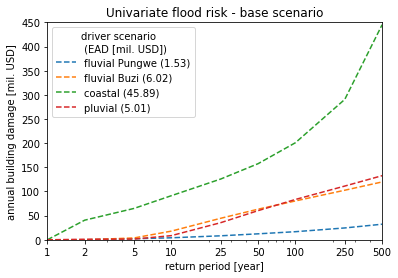

In [196]:
import matplotlib.pyplot as plt
exp0, factor = 'population_count', 1e3
exp0, factor = 'buildings_value', 1e6
fig, ax = plt.subplots(1,1, figsize=(6,4))
for key in ['qp', 'qb', 'h', 'p'][-4:]:
    risk0 = risk[key][f'{exp0}_base']/factor
    lab = f'{labs[key]} ({risk0:.2f})'
#     lab = f'{labs[key]}'
    ls = '-' if 'dep' in lab else '--'
    zorder = 1 if 'dep' in lab else 2
    df0 = dfs[key].copy()
    if 'rp' not in df0:
        df0 = df0.sort_values(f'{exp0}_base')
        df0['rp'] = (1/(1-np.arange(df0.index.size)/df0.index.size))
    (df0.set_index('rp')[f'{exp0}_base']/factor).plot(ls=ls, lw=1.5, ax=ax, label=lab, zorder=zorder)
ax.set_xlim([1, 500])
if 'build' in exp0:
    ax.set_ylim([0, 450])
else:
    ax.set_ylim([0, 120])
ax.set_xscale('log')
ax.set_xticks(rps)
ax.set_xticklabels(rps)
ax.set_ylabel(f'{ylabs[exp0]}')
ax.set_xlabel('return period [year]')
# ax.legend(title='driver scenario', loc='upper left')
ax.legend(title=f'driver scenario\n {legend_titles[exp0]}', loc='upper left')
ax.set_title('Univariate flood risk - base scenario')
# plt.savefig(os.path.join('../FIGURES', f'risk_curve_{exp0}_single.png'), dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Compound flood risk - base scenario')

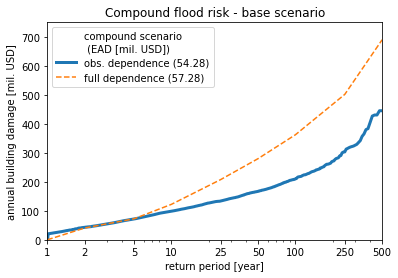

In [198]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
for key in ['obs', 'fulldep']:
    risk0 = risk[key][f'{exp0}_base']/factor
    lab = f'{labs[key]} ({risk0:.2f})'
    ls = '--' if 'full' in key else '-'
    lw = 3 if key == 'obs' else 1.5
    df0 = dfs[key].copy()
    if 'rp' not in df0:
        df0 = df0.sort_values(f'{exp0}_base')
        df0['rp'] = (1/(1-np.arange(df0.index.size)/df0.index.size))
    (df0.set_index('rp')[f'{exp0}_base']/factor).plot(ls=ls, lw=lw, ax=ax, label=lab)
ax.set_xlim([1, 500])
if 'build' in exp0:
    ax.set_ylim([0, 750])
else:
    ax.set_ylim([0, 220])
ax.set_xscale('log')
ax.set_xticks(rps)
ax.set_xticklabels(rps)
ax.set_ylabel(f'{ylabs[exp0]}')
ax.set_xlabel('return period [year]')
legend = ax.legend(title=f'compound scenario\n {legend_titles[exp0]}', loc='upper left')#, fontsize='large')
ax.set_title('Compound flood risk - base scenario')
# plt.savefig(f'../FIGURES/risk_curve_{exp0}_compound.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
key='magObs_timeObs_sum'
for pf in ['base', 'dikes', 'dryproofing', 'zoning']:
    exp = f'{exp0}_{pf}'
    risk0 = risk[key][exp]/factor
    pf = 'dry-proofing' if pf == 'dryproofing' else pf
    lab = f'{pf} ({risk0:.2f})'
#     ls = '-' if pf == 'base' else ':'
    lw = 3 if pf == 'base' else 1.5
    df0 = dfs[key].copy()
    if 'rp' not in df0:
        df0 = df0.sort_values(exp)
        df0['rp'] = (1/(1-np.arange(df0.index.size)/df0.index.size))
    (df0.set_index('rp')[exp]/factor).plot(ls='-', lw=lw, ax=ax, label=lab)
ax.set_xlim([1, 500])
if 'build' in exp0:
    ax.set_ylim([0, 200])
else:
    ax.set_ylim([0, 140])
ax.set_xscale('log')
ax.set_xticks(rps)
ax.set_xticklabels(rps)
ax.set_ylabel(f'cumulative {ylabs[exp0]}')
ax.set_xlabel('return period [year]')
ax.legend(title=f'adaptation scenario\n {legend_titles[exp0]}', loc='upper left')
ax.set_title(f'Compound flood risk - {legend_titles[exp0][1:5]}')
plt.savefig(f'../FIGURES/risk_curve_{exp0}_adaptation.png', dpi=300, bbox_inches='tight')

In [ ]:
_df = samples['magObs_timeObs']
np.sum(np.logical_and.reduce((_df['qb_rp']>10, _df['qp_rp']>10, _df['h_rp']>10)))

### RISK MAPS

In [ ]:
ds_risk = (ds_impact * ds['cof']).sum('rps').compute()

# bias correct to match totals
df00 = df_adapt.T
df00 = df00.rename({n:n.replace('buildings_value', 'cp_dam').replace('_base', '') for n in df00.index})
df00 = df00.rename({n:n.replace('population_count', 'cp_pop').replace('_base', '') for n in df00.index})

for dvar in df00.index:
    ds_risk[dvar] = ds_risk[dvar]/ds_risk[dvar].sum().item()*df00.loc[dvar].item()

In [ ]:
ds_risk = ds_risk.raster.reproject_like(mod0.staticmaps, 'nearest')
for dvar in ds_risk.data_vars:
    ds_risk[dvar] = ds_risk[dvar].where(mod0.staticmaps['msk']>0, -9999)
    ds_risk[dvar].raster.set_nodata(-9999)
ds_risk.raster.set_crs(mod0.crs)
dir_out = os.path.join('../03_models', 'risk')
ds_risk.raster.to_mapstack(dir_out, compress='lzw')